In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import time

In [26]:
#transform to timestamp and add features
def AddColumns(df):
    df['Begin'] = pd.to_datetime(df['Begin'])
    #df['Date'] = pd.DatetimeIndex(df.Begin).normalize()
    df['Weekday'] = df['Begin'].dt.day_name()
    #df['Hour'] = df['Begin'].dt.hour
    df['TimeOfDay'] = df['Begin'].dt.time
    #df['Year'] = df['Begin'].dt.year
    df['Month'] = df['Begin'].dt.month_name()
    #df['Day'] = df['Begin'].dt.day
    return df


def DryHours(df):
    '''
    Input:      - df with data per pump
                - string of the pump name (to access the rain column)
    Output:     - df with only dry hours according to our definition
    '''
    dry = df[df['rain_-15_class'] == 0]
    return dry


def preprocess_df(df):
    for col in df.columns:  # go through all of the columns
        if col == "hstWaarde":  # normalize the flow column 
            df[col] = (df[col]-df[col].min())/(df[col].max()- df[col].min()) #scale between 0 and 1 using min-max normalization
    df.dropna(inplace=True)  # cleanup again... jic. Those nasty NaNs love to creep in.
    return df

# dataaaaaa

In [24]:
data = pd.read_csv('../../../data/new_haar.csv')
data.drop(['Unnamed: 0', 'datumBeginMeting'], axis=1, inplace=True) #don't need these

In [16]:
# data.head()

,Unnamed: 0,datumBeginMeting,hstWaarde,Bokhoven,Begin,cumsum_previous_15,rain_-15_class
0,0,2018-01-01 00:00:00,1200.0,0.0583,2018-01-01 00:00:00,0.0583,1
1,1,2018-01-01 01:00:00,940.0,0.0448,2018-01-01 01:00:00,0.1031,1
2,2,2018-01-01 02:00:00,0.0,0.1409,2018-01-01 02:00:00,0.2440,1
3,3,2018-01-01 03:00:00,280.0,0.0714,2018-01-01 03:00:00,0.3154,1
4,4,2018-01-01 04:00:00,150.0,0.1340,2018-01-01 04:00:00,0.4494,1


In [27]:
# make it only dry
data = DryHours(data)
# reset the index
data = data.reset_index()
# only select the flow 
data = data[['hstWaarde']]
data.head()

,hstWaarde
0,1200.0
1,260.0
2,0.0
3,0.0
4,250.0


# use multiple timestamps as separate features

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back): # lookback = how many timestamps back do you want
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [30]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [32]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(data)

In [33]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [34]:
# reshape into X=t and Y=t+1
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [39]:
trainX.shape, trainY.shape

((6177, 1, 24), (6177,))

In [36]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [37]:
trainX.shape

(6177, 1, 24)

In [36]:
# # create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)


Epoch 1/100
 - 7s - loss: 0.0160
Epoch 2/100
 - 7s - loss: 0.0129
Epoch 3/100
 - 7s - loss: 0.0124
Epoch 4/100
 - 7s - loss: 0.0121
Epoch 5/100
 - 7s - loss: 0.0118
Epoch 6/100
 - 7s - loss: 0.0114
Epoch 7/100
 - 7s - loss: 0.0112
Epoch 8/100
 - 7s - loss: 0.0109
Epoch 9/100
 - 7s - loss: 0.0108
Epoch 10/100
 - 7s - loss: 0.0107
Epoch 11/100
 - 7s - loss: 0.0106
Epoch 12/100
 - 7s - loss: 0.0105
Epoch 13/100
 - 7s - loss: 0.0104
Epoch 14/100
 - 16s - loss: 0.0104
Epoch 15/100
 - 19s - loss: 0.0104
Epoch 16/100
 - 18s - loss: 0.0103
Epoch 17/100
 - 12s - loss: 0.0103
Epoch 18/100
 - 7s - loss: 0.0103
Epoch 19/100
 - 8s - loss: 0.0103
Epoch 20/100
 - 7s - loss: 0.0102
Epoch 21/100
 - 7s - loss: 0.0102
Epoch 22/100
 - 7s - loss: 0.0102
Epoch 23/100
 - 7s - loss: 0.0101
Epoch 24/100
 - 7s - loss: 0.0101
Epoch 25/100
 - 7s - loss: 0.0101
Epoch 26/100
 - 7s - loss: 0.0101
Epoch 27/100
 - 7s - loss: 0.0101
Epoch 28/100
 - 7s - loss: 0.0100
Epoch 29/100
 - 7s - loss: 0.0101
Epoch 30/100
 - 7s

In [37]:
# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])

In [38]:
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
# print('Test Score: %.2f RMSE' % (testScore))

Train Score: 114.38 RMSE
Test Score: 141.94 RMSE


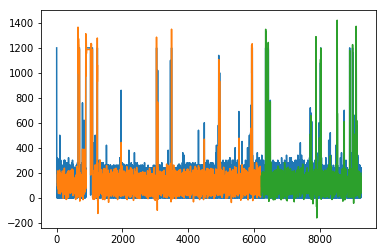

In [39]:
# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()

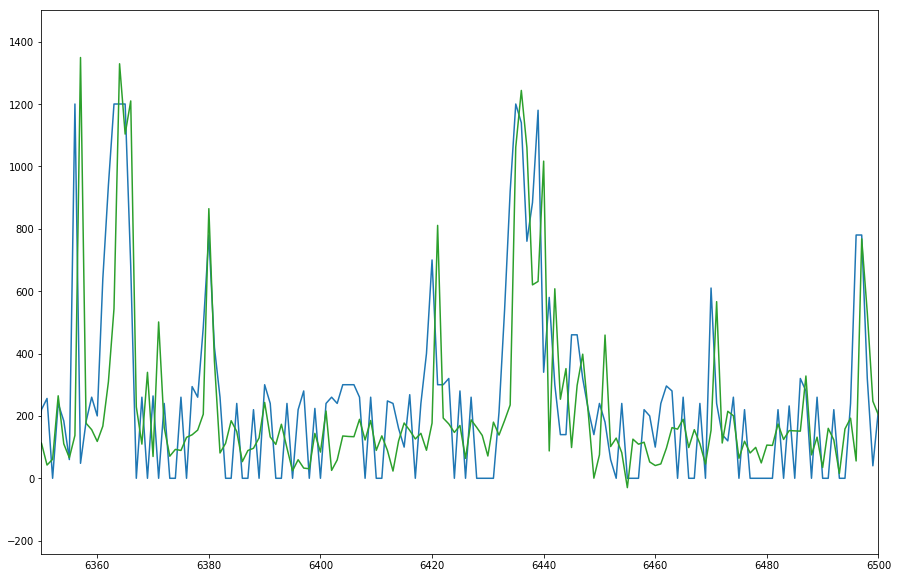

In [43]:
# fig = plt.figure(figsize=(15,10))
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.xlim(6350, 6500)
# plt.show()

# use multiple timestamps as one feature

In [16]:
# new pickle data
new_data = pd.read_pickle('../../../data/Bokhoven.pickle')
new_data.head()

,Unnamed: 0,day_ofthe_month,hour,day_ofthe_year,day_ofthe_week,holiday,flow,rain_hour,level,rain_N_ago,dates,datetime,Date,Weekday,Hour,TimeOfDay,Year,Month,Day,DayofYear
0,0,1,0,1,0,1,1200.0,0.0583,1.028333,1,2018-01-01 00:00:00,2018-01-01 00:00:00,2018-01-01,Monday,0,00:00:00,2018,January,1,1
1,1,1,1,1,0,1,940.0,0.0448,0.376667,1,2018-01-01 01:00:00,2018-01-01 01:00:00,2018-01-01,Monday,1,01:00:00,2018,January,1,1
2,2,1,2,1,0,1,0.0,0.1409,0.160000,1,2018-01-01 02:00:00,2018-01-01 02:00:00,2018-01-01,Monday,2,02:00:00,2018,January,1,1
3,3,1,3,1,0,1,280.0,0.0714,0.061667,1,2018-01-01 03:00:00,2018-01-01 03:00:00,2018-01-01,Monday,3,03:00:00,2018,January,1,1
4,4,1,4,1,0,1,150.0,0.1340,0.343333,1,2018-01-01 04:00:00,2018-01-01 04:00:00,2018-01-01,Monday,4,04:00:00,2018,January,1,1


In [17]:
# sort by time just in case
new_data = new_data.sort_values(by='datetime')

# drop everything unnecessary for now
new_data = new_data[['flow', 'rain_hour', 'Weekday', 'Hour']] # removed month for now
new_data.head()

,flow,rain_hour,Weekday,Hour
0,1200.0,0.0583,Monday,0
1,940.0,0.0448,Monday,1
2,0.0,0.1409,Monday,2
3,280.0,0.0714,Monday,3
4,150.0,0.1340,Monday,4


In [18]:
len(new_data)

14399

In [19]:
# create lags of flow and rain as features for the model

# flow
flow_lags = 24
# These are the "time lags"
shifts = np.arange(1, flow_lags).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"flow_lag_{}_hour".format(hour_shift): new_data.flow.shift(hour_shift) for hour_shift in shifts}

# Convert into a DataFrame for subsequent use
flow_shifts = pd.DataFrame(shifted_data)

# rain
rain_lags = 20
# These are the "time lags"
shifts = np.arange(1, rain_lags).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"rain_lag_{}_hour".format(hour_shift): new_data.flow.shift(hour_shift) for hour_shift in shifts}

# Convert into a DataFrame for subsequent use
rain_shifts = pd.DataFrame(shifted_data)

In [20]:
# combine the shifted data with old data
new_data_shifted = pd.concat([new_data,flow_shifts,rain_shifts], axis=1)

In [21]:
new_data_shifted.columns

Index(['flow', 'rain_hour', 'Weekday', 'Hour', 'flow_lag_1_hour',
       'flow_lag_2_hour', 'flow_lag_3_hour', 'flow_lag_4_hour',
       'flow_lag_5_hour', 'flow_lag_6_hour', 'flow_lag_7_hour',
       'flow_lag_8_hour', 'flow_lag_9_hour', 'flow_lag_10_hour',
       'flow_lag_11_hour', 'flow_lag_12_hour', 'flow_lag_13_hour',
       'flow_lag_14_hour', 'flow_lag_15_hour', 'flow_lag_16_hour',
       'flow_lag_17_hour', 'flow_lag_18_hour', 'flow_lag_19_hour',
       'flow_lag_20_hour', 'flow_lag_21_hour', 'flow_lag_22_hour',
       'flow_lag_23_hour', 'rain_lag_1_hour', 'rain_lag_2_hour',
       'rain_lag_3_hour', 'rain_lag_4_hour', 'rain_lag_5_hour',
       'rain_lag_6_hour', 'rain_lag_7_hour', 'rain_lag_8_hour',
       'rain_lag_9_hour', 'rain_lag_10_hour', 'rain_lag_11_hour',
       'rain_lag_12_hour', 'rain_lag_13_hour', 'rain_lag_14_hour',
       'rain_lag_15_hour', 'rain_lag_16_hour', 'rain_lag_17_hour',
       'rain_lag_18_hour', 'rain_lag_19_hour'],
      dtype='object')

In [22]:
# get dummies for weekday and hour of the day
data_shift_dum = pd.get_dummies(new_data_shifted, columns = ['Weekday', 'Hour'])
data_shift_dum

,flow,rain_hour,flow_lag_1_hour,flow_lag_2_hour,flow_lag_3_hour,flow_lag_4_hour,flow_lag_5_hour,flow_lag_6_hour,flow_lag_7_hour,flow_lag_8_hour,...,Hour_14,Hour_15,Hour_16,Hour_17,Hour_18,Hour_19,Hour_20,Hour_21,Hour_22,Hour_23
0,1200.0,0.0583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,940.0,0.0448,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.1409,940.0,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
3,280.0,0.0714,0.0,940.0,1200.0,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
4,150.0,0.1340,280.0,0.0,940.0,1200.0,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14394,0.0,0.0000,200.0,0.0,0.0,240.0,0.0,220.0,0.0,140.0,...,0,0,0,0,0,1,0,0,0,0
14395,240.0,0.0000,0.0,200.0,0.0,0.0,240.0,0.0,220.0,0.0,...,0,0,0,0,0,0,1,0,0,0
14396,0.0,0.0000,240.0,0.0,200.0,0.0,0.0,240.0,0.0,220.0,...,0,0,0,0,0,0,0,1,0,0
14397,220.0,0.0000,0.0,240.0,0.0,200.0,0.0,0.0,240.0,0.0,...,0,0,0,0,0,0,0,0,1,0


In [23]:
data_shift_dum.columns

Index(['flow', 'rain_hour', 'flow_lag_1_hour', 'flow_lag_2_hour',
       'flow_lag_3_hour', 'flow_lag_4_hour', 'flow_lag_5_hour',
       'flow_lag_6_hour', 'flow_lag_7_hour', 'flow_lag_8_hour',
       'flow_lag_9_hour', 'flow_lag_10_hour', 'flow_lag_11_hour',
       'flow_lag_12_hour', 'flow_lag_13_hour', 'flow_lag_14_hour',
       'flow_lag_15_hour', 'flow_lag_16_hour', 'flow_lag_17_hour',
       'flow_lag_18_hour', 'flow_lag_19_hour', 'flow_lag_20_hour',
       'flow_lag_21_hour', 'flow_lag_22_hour', 'flow_lag_23_hour',
       'rain_lag_1_hour', 'rain_lag_2_hour', 'rain_lag_3_hour',
       'rain_lag_4_hour', 'rain_lag_5_hour', 'rain_lag_6_hour',
       'rain_lag_7_hour', 'rain_lag_8_hour', 'rain_lag_9_hour',
       'rain_lag_10_hour', 'rain_lag_11_hour', 'rain_lag_12_hour',
       'rain_lag_13_hour', 'rain_lag_14_hour', 'rain_lag_15_hour',
       'rain_lag_16_hour', 'rain_lag_17_hour', 'rain_lag_18_hour',
       'rain_lag_19_hour', 'Weekday_Friday', 'Weekday_Monday',
       'Weekday_

### start with model

In [48]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)

In [49]:
# load the dataset
dataset = data.values
dataset = dataset.astype('float32')

In [50]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [51]:
# reshape into X=t and Y=t+1
look_back = 24
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [52]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [53]:
trainX.shape, testX.shape

((6177, 24, 1), (3031, 24, 1))

In [68]:
# create and fit the LSTM network
start = time.time()
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)
end = time.time()
print(f'Model training took {(end-start)/60:.2f} minutes')

Epoch 1/10
 - 35s - loss: 0.0206
Epoch 2/10
 - 33s - loss: 0.0137
Epoch 3/10
 - 33s - loss: 0.0131
Epoch 4/10
 - 33s - loss: 0.0126
Epoch 5/10
 - 36s - loss: 0.0122
Epoch 6/10
 - 30s - loss: 0.0117
Epoch 7/10
 - 30s - loss: 0.0114
Epoch 8/10
 - 31s - loss: 0.0112
Epoch 9/10
 - 29s - loss: 0.0111
Epoch 10/10
 - 29s - loss: 0.0110
Model training took 5.34 seconds


the cell above took 5.34 __MINUTES__

In [66]:
number = 4.5685457
a = 200
b = 100
print(f'This is a number: {(a-b)/10:.2f} bla')
print('This is a number: {:.2f}'.format(number))

This is a number: 10.00 bla
This is a number: 4.57


In [69]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 124.97 RMSE
Test Score: 142.56 RMSE


In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

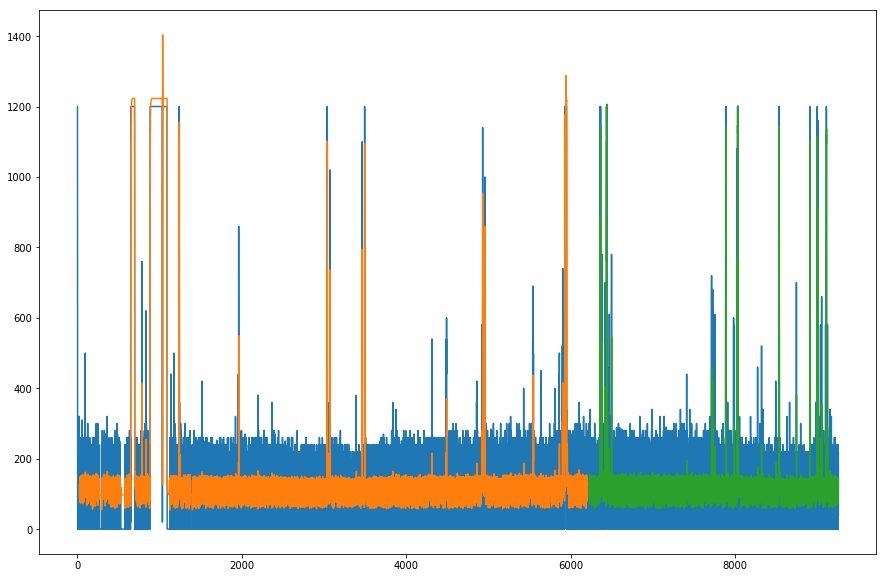

In [71]:
# plot baseline and predictions
fig = plt.figure(figsize=(15,10))

plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

to do
make dummies for day of the week, hour of the day
scale rain
scale flow

add proper activation - linear as final, relu for hidden
add proper error measure aka let's try mean absolute error
